# Issue #35: Mixture model mode
## gully
### Tue, March 1, 2016

Basically we want to add two spectra together (in the right proportions) to mimic a two-component photosphere.

## The mixture model

We have to get the scale factor right.

$$ f_{mix} = (1-c) \cdot \frac{f_1}{\bar f_1} + c \cdot q_m \cdot \frac{f_2}{\bar f_2} $$

where:  
$\frac{f_1}{\bar f_1}$ is the normalized spectrum of star 1  
$\frac{f_2}{\bar f_2}$ is the normalized spectrum of star 2  
$c$ is the solid angle ratio of $f_2$ to $f_1$  
$q_m$ is the wavelength-dependent specific flux ratio of of $f_2$ to $f_1$ for spectral order $m$

## Strategies for estimating the scale factor $q_m$

There are a few different Strategies for dealing with $q_m$:  

1. Directly synthetize un-normalized (raw) flux with the PCA process, rather than dividing out the mean, so $q_m$ disappears.
2. Approximate $q_m$ as the ratio of Black Bodies in the wavelength range of interest, using $T_{eff, 1}$ and $T_{eff, 2}$, ignore other parameter dependences.
3. Calculate $q_m$ as the ratio of un-normalized (raw) flux ratios $\frac{\bar f_2}{\bar f_1}$ for each grid point, for each spectral order chunk, interpolate between grid points.

**Strategy 1** is super hard.  The assumption of normalized, mean subtracted fluxes are so deeply imbedded in spectral emulation framework that Strategy 1 would require a massive rewrite of the PCA spectral emulator, and will introduce major problems in determining the PCA components.  So that's out.

**Strategy 2** will work OKAYish, but the black body is not a great estimate for the flux ratio in the presence of large molecular absorption bands for cool stellar photospheres, so some multiple simultaneous fiting of different spectral orders could get wonky.  So this is a good backup plan, or temporary demo, but should probably not be used for production.

<img src= ./BB_flux_rat_vs_PHOENIX.png width=400></img>

**Strategy 3** is probably about as close to the Right Thing to Do as we can get, but requires a few data engineering steps.

## Data engineering for Strategy 3

- Generate a temporary *un-*normalized (*i.e.* raw) grid in parallel with the *normalized* grid, vis-a-vis `grid.py --create`
- From the raw grid, compute the ratio of $q_m(\theta_{grid, 1}, \theta_{grid, 2}) = \bar f_2 / \bar f_1 $ for each grid point with every other grid point, for each spectral order
- Use 6-D regression to fit a function $\hat q_m(\theta_{\star, 1}, \theta_{\star, 2})$.

Which regression to use?  My first reaction is Gaussian Process, since it would mimic the spectral emulator.  But after messing around with it and thinking about dimensionality and other tradeoffs, I decided to just use a **linear interpolator**.  This choice might cause the $c$ parameter above to cling to the grid points, if the grid points have cuspy discontinuities from piecewise linear joints at the grid points.  So if we see that we can come back and make a fancier estimator.  For now we will leave it and move on.

In [1]:
import numpy as np

In [2]:
import Starfish
from Starfish.grid_tools import HDF5Creator

In [3]:
h5i = Starfish.grid_tools.HDF5Interface("libraries/PHOENIX_TRES_test.hdf5")

Double check that we're using raw fluxes (norm = False):

In [4]:
if Starfish.config["grid"]["norm"] ==  False : print("All good.") 

All good.


In [5]:
h5i.grid_points.shape

(36, 3)

Let's load the flux of each model grid point and compute the **mean flux ratio** with *every other* model grid point.  
There will be $N_{grid} \times N_{grid}$ pairs of flux ratios, only half of which are unique.

In [6]:
N_grid, D_dim = h5i.grid_points.shape

In [7]:
N_tot = N_grid*N_grid

In [8]:
d_grd = np.empty((N_tot, D_dim*2))
f_rat = np.empty(N_tot)

In [9]:
c = 0
for i in np.arange(N_grid):
    print(i, end=' ')
    for j in np.arange(N_grid):
        d_grd[c] = np.hstack((h5i.grid_points[i], h5i.grid_points[j]))
        f_rat[c] = np.mean(h5i.load_flux(h5i.grid_points[i]))/np.mean(h5i.load_flux(h5i.grid_points[j]))
        c += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 

We now have a six dimensional **design matrix** and a scalar that we can fit to.

In [10]:
d_grd.shape, f_rat.shape

((1296, 6), (1296,))

In [11]:
from scipy.interpolate import LinearNDInterpolator

In [12]:
interp_f_rat = LinearNDInterpolator(d_grd, f_rat)

In [13]:
interp_f_rat(6000,4.0, 0, 6200, 5.0, -1.0)

array(0.9394950270652771)

In [14]:
np.mean(h5i.load_flux([6000, 4.0, 0]))/np.mean(h5i.load_flux([6200, 5.0, -1.0]))

0.93949503

Checks out.

So now we can produce $q_m$ on demand!  
Just a reminder... we have to do this for **each order**.  The next step is to figure out how to implement this efficiently in parallel operations.

In [17]:
spec = h5i.load_flux(h5i.grid_points[i])

In [20]:
h5i.wl.shape, spec.shape

((16384,), (16384,))

In [21]:
import matplotlib.pyplot as plt

In [22]:
%matplotlib inline

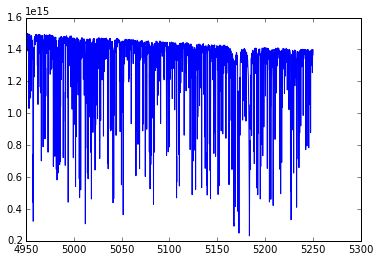

In [23]:
plt.plot(h5i.wl, spec)

In [26]:
Starfish.config["data"]["orders"]

[21]

# The end.